In [1]:
import requests
from bs4 import BeautifulSoup
import lxml

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

pd.set_option('display.max_colwidth', 200)
%matplotlib inline



In [2]:
# get all the open source and free to use and read papers from Europe PMC
# URL = 'http://europepmc.org/search?query=covid-19%20AND%20%28HAS_FT%3AY%29%20AND%20%28HAS_FT%3AY%29%20AND%20%28OPEN_ACCESS%3AY%29&page=1?javascript_support=no'
URL = 'http://europepmc.org/search?query=covid-19%20%20AND%20%28HAS_FT%3AY%29%20AND%20%28HAS_FT%3AY%29%20AND%20%28OPEN_ACCESS%3AY%29%20AND%20%28FIRST_PDATE%3A2020%29%20AND%20%28HAS_FT%3AY%20OR%20OPEN_ACCESS%3AY%29%20AND%20%28OPEN_ACCESS%3AY%29?javascript_support=no'
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'lxml')
open_acces_set = soup.findAll(attrs={"class" : "open-access"})

print('Total .. '+str(len(open_acces_set))+' free to use articles found!')

Total .. 25 free to use articles found!


In [3]:
# get all the article links
articles = []
for each_article in tqdm(open_acces_set):
    link = each_article.find('a', href=True)
    article_link = link['href'].split('#')
    articles.append('https://europepmc.org'+article_link[0]+'?javascript_support=no')

100%|██████████| 25/25 [00:00<00:00, 24585.60it/s]


In [4]:
# get all the p tags
list_p_text = []

for each_article_link in tqdm(articles):
    r = requests.get(each_article_link)
    article_soup = BeautifulSoup(r.text, 'lxml')
    for each_p_tag in article_soup.find_all('p'):
        if len(each_p_tag.text)>25:
            list_p_text.append(each_p_tag.text)

100%|██████████| 25/25 [01:10<00:00,  2.81s/it]


In [5]:
# get all the sentences
sentences = []
for each_par in tqdm(list_p_text):
    for each_sentence in each_par.split('.'):
        if len(each_sentence)>25:
            sentences.append(each_sentence.strip())

100%|██████████| 1271/1271 [00:00<00:00, 380565.42it/s]


In [6]:
# import spaCY and load gene disease ner models
import spacy
from spacy import util

## Test best model performance on test set
best_model_path = '/nfs/gns/literature/Santosh_Tirunagari/GitHub/spacy_models/pretrain_exp/best/'

print("Loading from", best_model_path)
ml_annotator = util.load_model_from_path(best_model_path)

# load this model for dependency
nlp_en = spacy.load('en')

Loading from /nfs/gns/literature/Santosh_Tirunagari/GitHub/spacy_models/pretrain_exp/best/


In [7]:
# get gene and disease pairs

def get_gene_disease_pairs(sent):
    GP =''
    DS = ''
    doc = ml_annotator(sent)
    for ent in doc.ents:
        if ent.label_ == 'GP':
            GP = ent.text
        elif ent.label_ == 'DS':
            DS = ent.text
    return [GP.strip(), DS.strip()]        

In [8]:
get_gene_disease_pairs("The infection routes and pathogenesis of 2019-nCov are not fully understood by far, and the study of 2019-nCoV host cell receptor ACE2 could be valuable for the prevention and treatment of the COVID-19")

['cell receptor ACE2', 'infection']

In [9]:
entity_pairs = []

for i in tqdm(sentences):
    entity_pairs.append(get_gene_disease_pairs(i))

100%|██████████| 2753/2753 [00:09<00:00, 289.86it/s]


In [10]:
# get relations
def get_relation(sent):

    doc = nlp_en(sent)

    # Matcher class object 
    matcher = Matcher(nlp_en.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [11]:
# extract relations

relations = []

for i in tqdm(sentences):
    relations.append(get_relation(i))
 

100%|██████████| 2753/2753 [00:28<00:00, 96.36it/s] 


In [12]:
# extract gene
source = [i[0] for i in entity_pairs]

# extract disease
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'gene':source, 'disease':target, 'edge':relations})

In [13]:
import numpy as np
kg_df['gene'].replace('', np.nan, inplace=True)
kg_df['disease'].replace('', np.nan, inplace=True)

kg_df['gene'].replace('HER2', np.nan, inplace=True) # This was an example for every article in EPMC, bettwr to remove

kg_df.dropna(subset=['gene','disease'], inplace=True)
kg_df


,gene,disease,edge
123,polymerase,infections,made
239,reverse transcriptase,SARS,collected from symptomatic
289,SARS,SARS,reported full
299,E6,SARS,replicate in other
309,CoV,SARS,Prior to
1401,reverse transcription-polymerase,infection15,developed
1724,villagers[41,CoV-2 infection,was
1832,ACE2,SARS,is
1834,ACE2,SARS,suggests
1980,CRP,viral infections,had


In [18]:
import os

kg_df.to_json (os.getcwd()+'/Export_DataFrame.json', orient='split')
kg_df.to_json (os.getcwd()+'/Export_DataFrame_1.json')

# Knowledge graph

In [20]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "gene", "disease", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

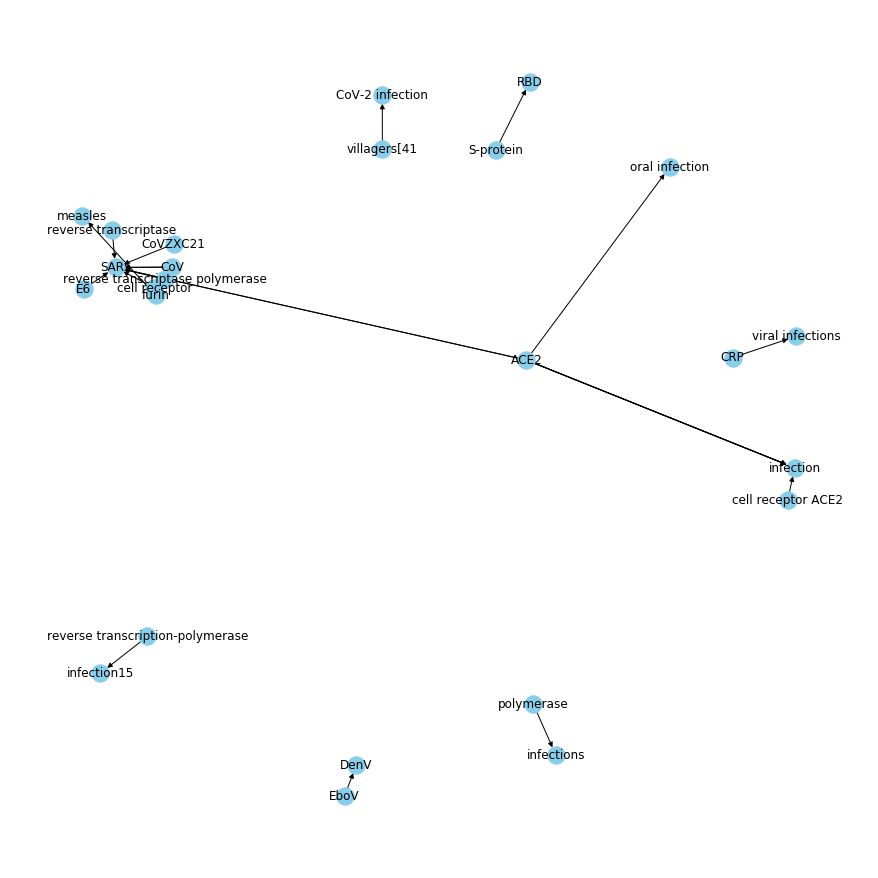

In [21]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [16]:
# G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="indicate"], "source", "target", 
#                           edge_attr=True, create_using=nx.MultiDiGraph())

# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
# nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
# plt.show()